In [2]:
import sqlite3
import pandas as pd 
from tqdm.auto import tqdm
from IPython.display import display, HTML
import re
import datetime
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Visualize HTML Data

In [3]:
## leave the same
if os.path.exists('../data/tr-story'):
    dp_path = '../data/tr-story/all-tr-articles-merged-processed.pkl'
else:
    dp_path = 'all-tr-articles-merged-processed.pkl' 

processed_diffs_df = pd.read_pickle(dp_path)

In [4]:
# wp, 1926979,	2, 3 - narrative started changing
# wp, 1926979, 0, 1 - when article started

In [6]:
### ---- Change as Needed ----
idx = 0  ## increment this this

## leave this the same
source, a_id, version_old, version_new, created_old, created_new, title_html, article_html = (
    processed_diffs_df.iloc[idx]
#     processed_diffs_df.loc[lambda df: df['a_id'] == 1925369].loc[lambda df: df['version_old'] == 17].iloc[0]
)

print('source: %s' % source)
print('article version index: %s' % idx)
print('article id: %s' % a_id)
print('old version num: %s' % version_old)
print('new version num: %s' % version_new)
print()
print('old date created: %s' % created_old)
print('new date created: %s' % created_new)

display(HTML(title_html))
display(HTML('<h3>Article Body</h3>'))
display(HTML(article_html))

source: nyt
article version index: 0
article id: 1925369
old version num: 0
new version num: 1

old date created: 2020-03-31 15:32:00+00:00
new date created: 2020-03-31 16:04:00+00:00


Old Version,New Version
Captain of Aircraft Carrier Pleads for Help as Virus Cases Increase Onboard,Captain of Aircraft Carrier Pleads for Help as Virus Cases Increase Onboard


s id,Old Version,New Version
0,"WASHINGTON—The captain of an American aircraft carrier deployed to the Pacific Ocean has pleaded with the Pentagon for more help as a coronavirus outbreak aboard his ship continues to spread, officials said Tuesday.","WASHINGTON—The captain of an American aircraft carrier deployed to the Pacific Ocean has pleaded with the Pentagon for more help as a coronavirus outbreak aboard his ship continues to spread, officials said Tuesday."
1,Military officials say dozens of sailors have been infected.,Military officials say dozens of sailors have been infected.
2,"The crisis aboard the Roosevelt played out like a slow - moving disaster and highlights the dangers to the Pentagon if the coronavirus manages to infiltrate some its most important assets , such as bomber fleets , elite Special Operations units and the talisman of American military power , aircraft carriers .","The crisis aboard the Roosevelt played out like a slow - moving disaster and highlights the dangers to the Pentagon if the coronavirus manages to infiltrate some of its most important assets , such as bomber fleets , elite Special Operations units and the talisman of American military power , aircraft carriers ."
3,"In a statement, a Navy official said that the commanding officer of the Roosevelt “alerted leadership in the Pacific Fleet on Sunday evening of continuing challenges in isolating the virus.”","In a statement, a Navy official said that the commanding officer of the Roosevelt “alerted leadership in the Pacific Fleet on Sunday evening of continuing challenges in isolating the virus.”"
4,"“The ship’s commanding officer advocated for housing more members of the crew in facilities that allow for better isolation,” the statement said.","“The ship’s commanding officer advocated for housing more members of the crew in facilities that allow for better isolation,” the statement said."
5,"“Navy leadership is moving quickly to take all necessary measures to ensure the health and safety of the crew of U.S.S. Theodore Roosevelt, and is pursuing options to address the concerns raised by the commanding officer.”","“Navy leadership is moving quickly to take all necessary measures to ensure the health and safety of the crew of U.S.S. Theodore Roosevelt, and is pursuing options to address the concerns raised by the commanding officer.”"
6,,"At its core, the issue on the Roosevelt, and other warships, stems from the near impossibility of putting adequate social distance between people to stop the spread of the illness."
7,,"Living quarters, hallways and doorways are cramped."
8,,Bathrooms and cafeterias are shared areas.
9,,"In his letter, Captain Crozier clearly outlined the challenge."


In [667]:
import re 

# Assign Diffs

In [708]:
has_live_in_title = (processed_diffs_df
 .assign(title_has_live=lambda df: 
         df['title_comp_html'].pipe(lambda s: 
            s.str.contains('Coronavirus Live Updates', flags=re.IGNORECASE) | 
            s.str.contains('Coronavirus US live', flags=re.IGNORECASE) | 
            s.str.contains('Coronavirus live news', flags=re.IGNORECASE) | 
            s.str.contains('US coronavirus live', flags=re.IGNORECASE) 
           )
        )
 .groupby('a_id')['title_has_live'].any().loc[lambda s: s].index
)

In [716]:
t = (processed_diffs_df
 .loc[lambda df: ~df['a_id'].isin(has_live_in_title)]
 .pipe(lambda df: 
      pd.concat([
        df.groupby('a_id').apply(lambda df: df['created_new'].max() - df['created_old'].min()),
        df.assign(c=1).groupby(['a_id'])['c'].sum(),
        df.groupby('a_id')['source'].aggregate(list).str.get(0),
    ], axis=1)
  )
)

In [734]:
t.iloc[8:15]['c'].sum()

59

In [724]:
processed_diffs_df.loc[lambda df: df['a_id'].isin(t.iloc[:8].index)].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
             13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
             26,  27,  28,  29,  30,  31,  32,  33,  72,  73,  74,  75,  76,
             77,  78,  79, 103, 104, 105, 106, 107, 108, 109, 110, 111, 145,
            146, 147, 148, 149, 150],
           dtype='int64')

In [735]:
processed_diffs_df.loc[lambda df: df['a_id'].isin(t.iloc[8:15].index)].index

Int64Index([174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
            187, 188, 189, 190, 191, 192, 193, 213, 214, 215, 216, 238, 239,
            240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252,
            253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265,
            266, 267, 268, 269, 270, 271, 272],
           dtype='int64')

# Get the Data

We focus on late March 2020 - May 2020 as the timeframe to initially focus on.

In [433]:
keywords = [
#     'US Navy',
    'tr sailors',
#     'guam',
#     'COVID',
    'thomas b. modly',
    'brett crozier',
    'u.s.s. theodore roosevelt',
    'uss theodore roosevelt',
    'teddy roosevelt',
#     'cno',
#     'secnav',
#     'Department of the Navy',
    'admiral mike gilday',
    'charles robert thacker jr.',
    'robert thacker jr.',
]

def highlight_keywords(t):
    for k in keywords:
        t = re.sub(k, '<span style="background-color:yellow">%s</span>' % k, t, flags=re.IGNORECASE)
    return t

### generate BigQuery expression

In [388]:
all_regexp = []
for k in keywords:
    where_exp = 'REGEXP_CONTAINS(sent_old, r"(?i)%s") or REGEXP_CONTAINS(sent_new, r"(?i)%s")' % (k, k)
    all_regexp.append(where_exp)

In [390]:
' OR '.join(all_regexp)

'REGEXP_CONTAINS(sent_old, r"(?i)tr sailors") or REGEXP_CONTAINS(sent_new, r"(?i)tr sailors") OR REGEXP_CONTAINS(sent_old, r"(?i)thomas b. modly") or REGEXP_CONTAINS(sent_new, r"(?i)thomas b. modly") OR REGEXP_CONTAINS(sent_old, r"(?i)brett crozier") or REGEXP_CONTAINS(sent_new, r"(?i)brett crozier") OR REGEXP_CONTAINS(sent_old, r"(?i)u.s.s. theodore roosevelt") or REGEXP_CONTAINS(sent_new, r"(?i)u.s.s. theodore roosevelt") OR REGEXP_CONTAINS(sent_old, r"(?i)uss theodore roosevelt") or REGEXP_CONTAINS(sent_new, r"(?i)uss theodore roosevelt") OR REGEXP_CONTAINS(sent_old, r"(?i)teddy roosevelt") or REGEXP_CONTAINS(sent_new, r"(?i)teddy roosevelt") OR REGEXP_CONTAINS(sent_old, r"(?i)admiral mike gilday") or REGEXP_CONTAINS(sent_new, r"(?i)admiral mike gilday") OR REGEXP_CONTAINS(sent_old, r"(?i)charles robert thacker jr.") or REGEXP_CONTAINS(sent_new, r"(?i)charles robert thacker jr.") OR REGEXP_CONTAINS(sent_old, r"(?i)robert thacker jr.") or REGEXP_CONTAINS(sent_new, r"(?i)robert thacke

In [544]:
dbs = glob.glob('../data/diffengine-diffs/db/*.db')
dbs_of_interest = ['nyt', 'washpo', 'guardian', 'r-bbc']
main_dbs = list(filter(lambda x: any(map(lambda y: y in x, dbs_of_interest)), dbs))

In [546]:
tqdm.pandas()
all_articles = []
for db in main_dbs:        
    con = sqlite3.connect(db)
    articles = pd.read_sql('SELECT * FROM entryversion WHERE created > "2020-01-01"', con=con)
    ### 
    ids_with_hits = (
        articles.loc[lambda df: 
             df['summary']
                .str.lower()
                .progress_apply(lambda x: any(map(lambda k: k in x, keywords)))
        ]['entry_id'].unique()
    )
    ### 
    relevant_articles = articles.loc[lambda df: df['entry_id'].isin(ids_with_hits)]
    all_articles.append(relevant_articles)

  0%|          | 0/8946 [00:00<?, ?it/s]

  0%|          | 0/42698 [00:00<?, ?it/s]

  0%|          | 0/117773 [00:00<?, ?it/s]

  0%|          | 0/46503 [00:00<?, ?it/s]

In [547]:
all_articles_df = pd.concat(all_articles)

In [548]:
all_articles_df.drop_duplicates('entry_id')['source'].value_counts()

nytimes     42
guardian    26
washpo      11
bbc          5
Name: source, dtype: int64

In [554]:
all_articles_df['source'].value_counts()

nytimes     1366
guardian     595
washpo        55
bbc           21
Name: source, dtype: int64

In [552]:
all_articles_df.drop_duplicates('entry_id')['num_versions'].median()

22.0

In [553]:
(all_articles_df
 .groupby('source')
 .apply(lambda df: df.drop_duplicates('entry_id')['num_versions'].median())
 .sort_values(ascending=False)
)

source
nytimes     35.5
guardian    22.0
washpo       5.0
bbc          4.0
dtype: float64

In [186]:
plt.rc('font', size=14)

Text(0.5, 0, 'Num. Versions')

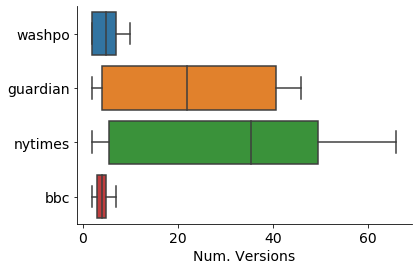

In [188]:
ax = sns.boxplot(
    y='source', 
    x='num_versions', 
    data=all_articles_df.drop_duplicates('entry_id')[['entry_id', 'source', 'num_versions']]
)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('')
ax.set_xlabel('Num. Versions')

In [555]:
all_articles_df['created'] = pd.to_datetime(all_articles_df['created'])

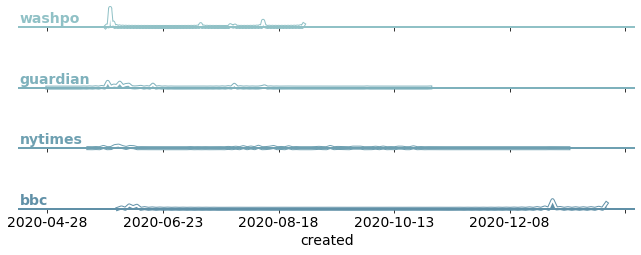

In [556]:
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .4, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)


# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(
    all_articles_df.assign(created=lambda df: df['created'].pipe(lambda s: s - s.min()).dt.total_seconds()), 
    row="source", 
    hue="source", 
    aspect=10,
    height=1, 
    palette=pal
)


# Draw the densities in a few steps
g.map(sns.kdeplot, "created", clip_on=False, shade=True, alpha=1, lw=4, bw=.2) 
g.map(sns.kdeplot, "created", color="w", clip_on=False, lw=2, bw=1)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

g.map(label, "created")

# Set the subplots to overlap
# g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], xticklabels=all_articles_df['created'].pipe(lambda s: pd.Series(pd.date_range(s.min(), s.max(), 6)).dt.strftime('%Y-%m-%d').tolist()))
g.despine(bottom=True, left=True)

# Load BigQuery Results

In [557]:
import json
output = []
for line in open('../data/bq-results-20210323-190027-l4dvrx3npx27.json'):
    t = json.loads(line)
    output.append(t)

In [558]:
data_df = pd.DataFrame(output)

In [559]:
data_df.drop(['__key__', '__error__', '__has_error__'], axis=1, inplace=True)
data_df['version_old'] = data_df['version_old'].str.get('integer').astype(int)
data_df['version_new'] = data_df['version_new'].str.get('integer').astype(int)
data_df['a_id'] = data_df['a_id'].astype(int)

In [560]:
found_diffs = (data_df
               .loc[lambda df: df['a_id'].isin(all_articles_df['entry_id'])]
              )

In [561]:
(found_diffs
 .drop_duplicates('a_id')['source'].value_counts())

nyt         23
guardian    19
wp          10
bbc-2        5
Name: source, dtype: int64

In [562]:
(found_diffs['a_id']
 .drop_duplicates()
 .loc[lambda s: ~s.isin(all_articles_df['entry_id'])]
)

Series([], Name: a_id, dtype: int64)

In [576]:
diffs_df = (
    found_diffs
     .groupby(['source', 'a_id', 'version_old', 'version_new'])
     .apply(lambda df: 
            df.sort_values('s_idx')
            .pipe(lambda df: (
                df[['sent_old', 'tag_old']]
                    .rename(columns={'sent_old':'text', 'tag_old': 'tag'})
                    .to_dict(orient='records'), 
                df[['sent_new', 'tag_new']]
                    .rename(columns={'sent_new':'text', 'tag_new': 'tag'})
                    .to_dict(orient='records')
            )
           )
       )
)

In [580]:
merged_diffs_df = (
    diffs_df
    .to_frame('vers_text')
    .reset_index()
    .merge(
         all_articles_df[['entry_id', 'version', 'title', 'created']]
             .rename(columns={'title': 'title_old', 'created': 'created_old'}),
         left_on=['a_id', 'version_old'], 
         right_on=['entry_id', 'version'],
         how='left'
     )
    .drop(['entry_id', 'version'], axis=1)
#  .set_index(['a_id', 'version_old', 'version_new'])
    .merge(
         all_articles_df[['entry_id', 'version', 'title', 'created']]
             .rename(columns={'title': 'title_new', 'created': 'created_new'}),
         left_on=['a_id', 'version_new'], 
         right_on=['entry_id', 'version'],
         how='left'
     )
 .drop(['entry_id', 'version'], axis=1)
)

In [582]:
merged_diffs_df

,source,a_id,version_old,version_new,vers_text,title_old,created_old,title_new,created_new
0,bbc-2,1928517,0,1,([{'text': 'The acting US Navy secretary has s...,Acting US Navy chief resigns over ship Covid-1...,2020-04-07 20:42:00+00:00,Coronavirus warship row: Acting US Navy secret...,2020-04-07 21:14:00+00:00
1,bbc-2,1928517,1,2,([{'text': 'The acting secretary of the US Nav...,Coronavirus warship row: Acting US Navy secret...,2020-04-07 21:14:00+00:00,Coronavirus warship row: Acting US Navy secret...,2020-04-07 21:46:00+00:00
2,bbc-2,1928517,2,3,([{'text': 'The acting secretary of the US Nav...,Coronavirus warship row: Acting US Navy secret...,2020-04-07 21:46:00+00:00,Coronavirus warship row: Acting US Navy secret...,2020-04-07 22:18:00+00:00
3,bbc-2,1928517,3,4,([{'text': 'The acting secretary of the US Nav...,Coronavirus warship row: Acting US Navy secret...,2020-04-07 22:18:00+00:00,Coronavirus warship row: Acting US Navy secret...,2020-04-08 00:12:00+00:00
4,bbc-2,1930684,0,1,([{'text': 'A sailor who was serving aboard th...,Coronavirus: First sailor on virus-stricken US...,2020-04-13 15:08:00+00:00,Coronavirus: First sailor on virus-stricken US...,2020-04-13 17:56:00+00:00
...,...,...,...,...,...,...,...,...,...
668,wp,1961851,0,1,([{'text': 'Navy leaders have upheld the firin...,Navy upholds firing of aircraft carrier captai...,2020-06-19 19:38:00+00:00,Navy upholds firing of aircraft carrier captai...,2020-06-19 20:10:00+00:00
669,wp,1961851,1,2,([{'text': 'Navy leaders have upheld the firin...,Navy upholds firing of aircraft carrier captai...,2020-06-19 20:10:00+00:00,Navy upholds firing of aircraft carrier captai...,2020-06-19 22:58:00+00:00
670,wp,1961851,2,3,([{'text': 'Navy leaders have upheld the firin...,Navy upholds firing of aircraft carrier captai...,2020-06-19 22:58:00+00:00,Navy upholds firing of aircraft carrier captai...,2020-06-19 23:30:00+00:00
671,wp,1961851,3,4,([{'text': 'The U.S. Navy has upheld the remov...,Navy upholds firing of aircraft carrier captai...,2020-06-19 23:30:00+00:00,Navy upholds firing of aircraft carrier captai...,2020-06-20 00:00:00+00:00


# Process Data

In [584]:
merged_diffs_df.iloc[idx]

source                                                     bbc-2
a_id                                                     1928517
version_old                                                    0
version_new                                                    1
vers_text      ([{'text': 'The acting US Navy secretary has s...
title_old      Acting US Navy chief resigns over ship Covid-1...
created_old                            2020-04-07 20:42:00+00:00
title_new      Coronavirus warship row: Acting US Navy secret...
created_new                            2020-04-07 21:14:00+00:00
Name: 0, dtype: object

In [586]:
import sys
sys.path.append('../util')
import util_newssniffer_parsing as unp

for t in ['title_old', 'title_new',]:
    merged_diffs_df[t] = merged_diffs_df[t].fillna('')

html_comps = []
for idx in tqdm(range(len(merged_diffs_df))):
    source, a_id, version_old, version_new, (vars_old, vars_new), title_old, created_old, title_new, created_new = (
        merged_diffs_df.iloc[idx]
    )
    vars_title_old, vars_title_new = unp.get_word_diffs(title_old, title_new)
    title_html1, title_html2 = unp.html_compare_sentences(vars_title_old, vars_title_new)

    output = {
        'source': source,
        'a_id': a_id,
        'version_old' : version_old ,
        'version_new' : version_new ,
        'created_old': created_old,
        'created_new': created_new,
        'title_comp_html': '<h3>Headline</h3><table><tr><th>Old Version</th><th>New Version</th></tr><tr><td>%s</td><td>%s</td></tr></table>' % (title_html1, title_html2),
        'article_comp_html': unp.html_compare_articles(vars_old, vars_new, use_sids=True),
    }
    html_comps.append(output)

  0%|          | 0/673 [00:00<?, ?it/s]

In [611]:
(pd.DataFrame(html_comps)
 .sort_values(['a_id', 'created_old'])
 .iloc[2:]
 .reset_index(drop=True)
 .to_pickle('../data/tr-story/all-tr-articles-merged-processed.pkl'))

# Explore Why We Haven't Processed Many Articles

In [495]:
found_diffs.drop_duplicates(['a_id', 'version_old', 'version_new'])['source'].value_counts()

nyt         358
guardian    259
wp           40
bbc-2        16
Name: source, dtype: int64

In [423]:
(all_articles_df
    .drop_duplicates('entry_id')['source']
    .value_counts())

nytimes     42
guardian    26
washpo      11
bbc          5
Name: source, dtype: int64

In [449]:
t = (
    all_articles_df
        .loc[lambda df: ~df['entry_id'].isin(found_diffs['a_id'])]
        .loc[lambda df: df['source'] == 'nytimes']
        .drop_duplicates('entry_id')
        ['summary']
        .iloc[3]
)

In [ ]:
display(HTML(highlight_keywords(t)))

In [461]:
data_processor_iter = unp.get_sentence_diff_stats(
    all_articles_df.loc[lambda df: df['entry_id']==1931320],
    get_sentence_vars=True,
    output_type='iter'
)

In [486]:
con = sqlite3.connect('../data/diffengine-diffs/db/newssniffer-nytimes.db')
articles = pd.read_sql('''
    select * from entryversion
    where created > "2020-01-01" 
    and entry_id in (
        1928363, 1928259, 1928487,
        1928673, 1928135, 1928850,
        1927767, 1930617, 1929003,
        1927925,1927602, 1929119,
        1930716, 1931320, 1931246,
        1930367, 1925130, 1922010, 
        1922434
    )
''', con=con)

In [501]:
(all_articles_df
 .loc[lambda df: ~df['entry_id'].isin(found_diffs['a_id'])]
 .loc[lambda df: df['source'] == 'guardian']
 .drop_duplicates('entry_id')
#  ['summary']
)

,index,id,title,url,summary,created,archive_url,entry_id,num_versions,version,source,joint_key
6374,221443,1926126-1,Coronavirus live news: Global cases near milli...,https://www.theguardian.com/world/live/2020/ap...,Trump says federal stockpile of personal prote...,2020-04-02 00:33:00+00:00,https://www.newssniffer.co.uk/articles/1926126...,1926126,45,1,guardian,1926126-1
7447,226690,1928566-2,Coronavirus live news: Trump threatens to stop...,https://www.theguardian.com/world/live/2020/ap...,Boris Johnson still in intensive care; top EU ...,2020-04-08 00:36:00+00:00,https://www.newssniffer.co.uk/articles/1928566...,1928566,46,2,guardian,1928566-2
7659,227474,1928916-4,Coronavirus live news: global cases pass 1.5m ...,https://www.theguardian.com/world/live/2020/ap...,Boris Johnson still in intensive care but cond...,2020-04-09 02:08:00+00:00,https://www.newssniffer.co.uk/articles/1928916...,1928916,46,4,guardian,1928916-4
8027,229267,1930033-34,Coronavirus live news: US overtakes Italy as c...,https://www.theguardian.com/world/live/2020/ap...,"US death toll tops 19,600. Italy and India ext...",2020-04-11 19:56:00+00:00,https://www.newssniffer.co.uk/articles/1930033...,1930033,43,34,guardian,1930033-34
8307,230401,1930550-35,Coronavirus latest news: death toll in Italy p...,https://www.theguardian.com/world/live/2020/ap...,Spain records another drop in daily death toll...,2020-04-13 19:18:00+00:00,https://www.newssniffer.co.uk/articles/1930550...,1930550,46,35,guardian,1930550-35
9501,237310,1936066-0,Coronavirus live news: Brazil’s health system ...,https://www.theguardian.com/world/live/2020/ap...,Leader of US group peddling bleach as ‘miracle...,2020-04-25 01:02:00+00:00,https://www.newssniffer.co.uk/articles/1936066...,1936066,46,0,guardian,1936066-0
14217,265338,1954950-16,Coronavirus live news: Brazil cases surge past...,https://www.theguardian.com/world/live/2020/ju...,New York urges protesters to get tested; Turke...,2020-06-05 08:48:00+00:00,https://www.newssniffer.co.uk/articles/1954950...,1954950,45,16,guardian,1954950-16


# Prepare Individual Diffs

In [281]:
import sqlite3
with sqlite3.connect('../data/diffengine-diffs/output/wp.db') as conn:
    wp_sentence_diffs_df = pd.read_sql('select * from sentence_diffs', con=conn)

In [282]:
wp_army_diffs = (wp_sentence_diffs_df
 .loc[lambda df: df['a_id'].isin((
     all_articles_df
         .loc[lambda df: df['source'] == 'washpo']
         ['entry_id']
    ))
 ]
)

In [311]:
diffs_df = (
    wp_army_diffs
     .groupby(['a_id', 'version_old', 'version_new'])
     .apply(lambda df: 
            df.sort_values('s_idx')
            .pipe(lambda df: (
                df[['sent_old', 'tag_old']].rename(columns={'sent_old':'text', 'tag_old': 'tag'}).to_dict(orient='records'), 
                df[['sent_new', 'tag_new']].rename(columns={'sent_new':'text', 'tag_new': 'tag'}).to_dict(orient='records')
            )
           )
       )
)

merged_diffs_df = (diffs_df.to_frame('vers_text')
 .reset_index()
 .merge(
     all_articles_df[['entry_id', 'version', 'title', 'created']]
         .rename(columns={'title': 'title_old', 'created': 'created_old'}),
     left_on=['a_id', 'version_old'], 
     right_on=['entry_id', 'version'],
     how='left'
 )
 .drop(['entry_id', 'version'], axis=1)
#  .set_index(['a_id', 'version_old', 'version_new'])
 .merge(
     all_articles_df[['entry_id', 'version', 'title', 'created']]
         .rename(columns={'title': 'title_new', 'created': 'created_new'}),
     left_on=['a_id', 'version_new'], 
     right_on=['entry_id', 'version'],
     how='left'
 )
 .drop(['entry_id', 'version'], axis=1)
)

In [ ]:
merged_diffs_df.to_pickle('../data/tr-story/wp-tr-articles-merged.pkl')

In [55]:
(relevant_articles
 .assign(created=lambda df: pd.to_datetime(df['created']))
 .assign(c=1)
 .groupby('entry_id')
 .apply(lambda df: pd.Series({
     'min_date':df['created'].min().date(),
     'max_date':df['created'].max().date(),
     'count':df['c'].sum()
 }))
)

,min_date,max_date,count
entry_id,,,
1922010,2020-03-24,2020-03-24,8
1922434,2020-03-24,2020-03-24,7
1925130,2020-03-31,2020-04-01,11
1925369,2020-03-31,2020-09-02,35
1925507,2020-03-31,2020-03-31,7
1926793,2020-04-03,2020-09-04,6
1927602,2020-04-05,2020-09-02,38
1927767,2020-04-05,2020-09-03,42
1927925,2020-04-06,2020-09-03,38


In [62]:
t = relevant_articles.sort_values('created').iloc[-1]['summary']

In [65]:
display(HTML(highlight_keywords(t)))